In [1]:
!pip install num2words
!pip install emoji

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 6.6 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=b361645b0048cd5a8c2b5f209c9924c3adcbfd54f9613acfca2f3e4812698eae
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built docopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 16.0 MB/s eta 0:00:00


In [ ]:
import re
import nltk
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from num2words import num2words
import emoji

nltk.download('stopwords')

MODEL_NAME = "asafaya/bert-base-arabic"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('ground_truth.csv')
df = df.drop(columns=['id'])

label_map = {"human": 0, "machine": 1}
df["label"] = df["label"].map(label_map)

stopwords_arabic = set(stopwords.words('arabic'))

# Arabic Text Cleaning Functions
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_emojis(text):
    return emoji.replace_emoji(text, replace="")

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def numbers_to_arabic_words(text):
    def replace(match):
        num = int(match.group())
        return num2words(num, lang='ar')
    return re.sub(r'\d+', replace, text)


def clean_text(text):
    text = str(text).strip()

    text = remove_emojis(text)
    text = numbers_to_arabic_words(text)
    text = remove_urls_handles(text)

    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_punctuation(text)

    text = normalize_whitespace(text)
    return text


cleaned_texts = df["content"].astype(str).apply(clean_text).tolist()
labels = torch.tensor(df['label'].values, dtype=torch.long)

# Tokenization
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [4]:
# Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

model = BertClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

criterion = nn.CrossEntropyLoss()

for epoch in range(3):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == batch_labels).sum().item()
        train_total += batch_labels.size(0)

    train_acc = train_correct / train_total

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

/tmp/ipython-input-2229955769.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch 1 | Train Loss: 31.0560 | Train Acc: 0.9200
Epoch 2 | Train Loss: 5.6122 | Train Acc: 0.9889
Epoch 3 | Train Loss: 2.8702 | Train Acc: 0.9943


In [13]:
model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        batch_labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        batch_preds = torch.argmax(outputs, dim=1)

        preds.extend(batch_preds.cpu().numpy())
        true_labels.extend(batch_labels.cpu().numpy())

label_map_r = {0: "human", 1: "machine"}
pred_labels = [label_map_r[p] for p in preds]

submission_df = pd.DataFrame({"label": pred_labels})

submission_df.to_csv("predictions.csv", index=False)
torch.save(model.state_dict(), "bert_classifier.pt")

/tmp/ipython-input-2229955769.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Classification Report (TRAIN):
              precision    recall  f1-score   support

       human       1.00      1.00      1.00      2649
     machine       1.00      1.00      1.00      2649

    accuracy                           1.00      5298
   macro avg       1.00      1.00      1.00      5298
weighted avg       1.00      1.00      1.00      5298

Macro F1: 0.9984899927820059


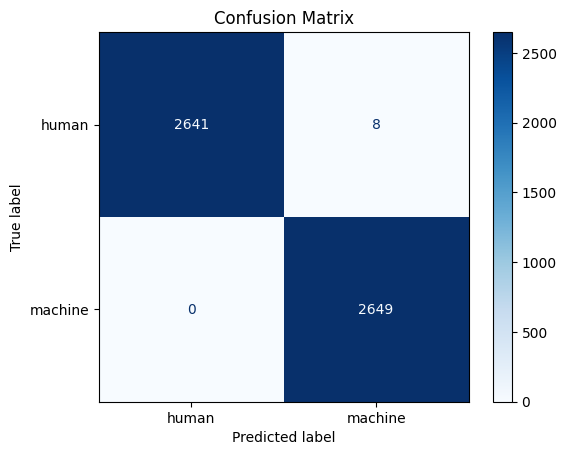

In [14]:
print("Classification Report (TRAIN):")
print(classification_report(
    true_labels,
    preds,
    target_names=["human", "machine"],
    digits=2
))

print("Macro F1:", f1_score(true_labels, preds, average='macro'))

cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["human", "machine"]
)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [8]:
# Testing on a different dataset

Classification Report:
              precision    recall  f1-score   support

       human      0.937     0.861     0.897      1000
     machine      0.871     0.942     0.905      1000

    accuracy                          0.901      2000
   macro avg      0.904     0.901     0.901      2000
weighted avg      0.904     0.901     0.901      2000

Macro F1: 0.901338169933233


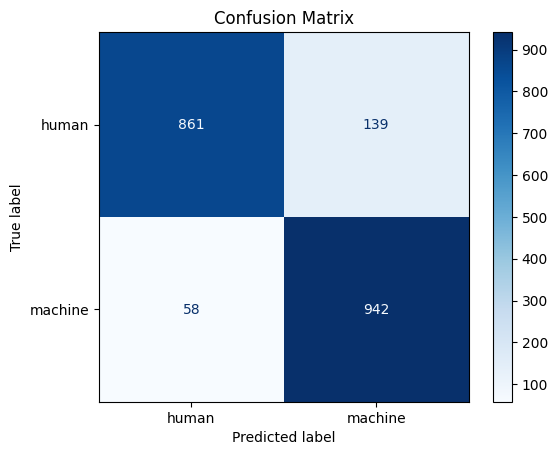

In [16]:
df = pd.read_parquet("by_polishing-00000-of-00001.parquet")

human_col = 'original_abstract'
ai_cols = [
    'allam_generated_abstract',
    'jais_generated_abstract',
    'llama_generated_abstract',
    'openai_generated_abstract'
]

def make_df(col, df, label):
    out = df[[col]].rename(columns={col: "text"})
    out["label"] = label
    return out

df_human = make_df(human_col, df, 0)
df_ai = make_df(ai_cols[0], df, 1)

df_test = pd.concat([df_human[:1000], df_ai[:1000]], ignore_index=True)
df_test["text"] = df_test["text"].astype(str).apply(clean_text)

encodings = tokenizer(
    df_test["text"].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

model.eval()
preds = []

with torch.no_grad():
    for i in range(0, len(df_test), 32):
        input_ids = encodings["input_ids"][i:i+32].to(device)
        attention_mask = encodings["attention_mask"][i:i+32].to(device)

        outputs = model(input_ids, attention_mask)
        batch_preds = torch.argmax(outputs, dim=1)

        preds.extend(batch_preds.cpu().numpy())

# --- Evaluation ---
y_true = df_test["label"].values
y_pred = preds

print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=["human", "machine"],
    digits=3
))

print("Macro F1:", f1_score(y_true, y_pred, average="macro"))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["human", "machine"]
)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


#### 6 epoches result

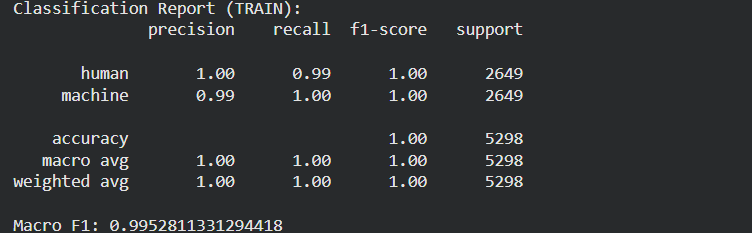

Test results:

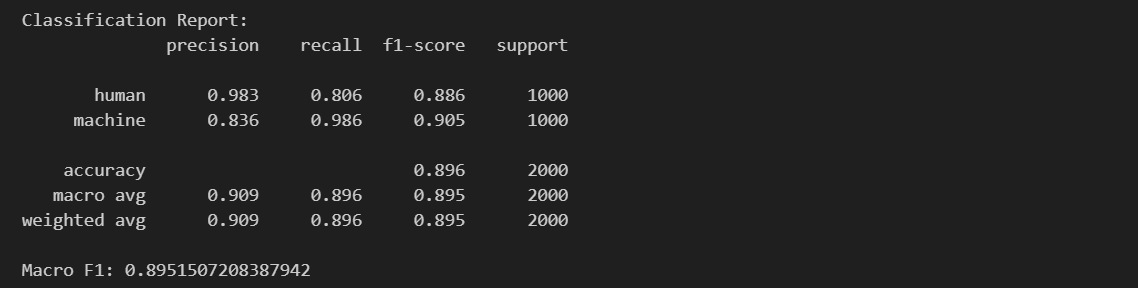